# 1. Tổng quan về bài toán





Thị trường bất động sản là một trong những thị trường được chú trọng nhất về giá cả và liên tục biến động. Đây là một trong những lĩnh vực chính để áp dụng các ý tưởng của máy học về cách cải thiện chi phí với độ chính xác cao. Mục tiêu của dự án là dự đoán giá trị thị trường của bất động sản. Hệ thống này giúp tìm giá khởi điểm cho một bất động sản dựa trên các biến đặc điểm của ngôi nhà. Bằng cách phá vỡ các khuôn mẫu thị trường và phạm vi giá trị trong quá khứ, kết hợp với những cải tiến về mặt kỹ thuật sẽ có thể dự đoán được giá trị trong tương lai. Việc này có nghĩa là dự đoán giá nhà ở **Ames** (Ames là một thành phố ở Quận Story, Iowa, Hoa Kỳ). Nó sẽ giúp khách hàng đưa các nguồn lực vào một yêu cầu mà không cần thông qua một nhà môi giới.

## 1.1 Vấn đề cần giải quyết

Ở đây chúng ta có một vấn đề: Yêu cầu một người mua nhà ở Ames, Iowa mô tả ngôi nhà mơ ước của họ, và họ có thể sẽ không bắt đầu với chiều cao của trần nhà hoặc khoảng cách với các siêu thị gần đó. Với những mô tả này, bạn bắt đầu dự đoán giá của ngôi nhà mơ ước này sẽ là bao nhiêu.

Dựa trên thông tin đó, chúng ta có thể thấy rằng chúng ta đang giải quyết **vấn đề hồi quy**: đưa ra một đầu vào bao gồm **tất cả các đặc điểm về ngôi nhà**, trả về **giá của ngôi nhà** như một đầu ra. Lần này, chúng ta sử dụng tập dữ liệu từ một cuộc thi trên [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description). Bộ dữ liệu này chứng minh rằng có nhiều sự ảnh hưởng nhiều hơn đến việc đàm phán giá so với số lượng phòng ngủ hoặc hàng rào màu trắng. Với 79 biến số mô tả (hầu hết) mọi khía cạnh của một ngôi nhà dân dụng, chúng ta sẽ dự đoán giá cuối cùng của mỗi ngôi nhà ở Ames. Sử dụng **MSE** (Mean squared error) giữa giá trị dự đoán và giá trị được quan sát thực làm chỉ số đo sự sai lệch, chúng ta muốn chỉ số này gần bằng 0. Đây là cách chúng ta đánh giá và chọn mô hình tốt nhất từ một loạt mô hình hồi quy với các tham số khác nhau. Mô hình có RMSE nhỏ nhất là mô hình cuối cùng của chúng ta.

Trong dự án này, chúng tôi sẽ thực hiện những việc sau:

1. Tìm hiểu về tập dữ liệu thông qua các phân tích về dữ liệu bị thiếu, phân bố của dữ liệu đầu ra và độ tương quan giữa các đặc trưng.
2. Xử lý các dữ liệu bị thiếu.
3. Chuyển các biến hạng mục dưới sạng số sang biến hạng mục, bổ sung thêm biến mới.
4. Mã hoá biến hạng mục sử dụng mã hóa số nguyên.
5. Mã hóa các biến hạng mục còn lại sử dụng mã hóa one-hot.
6. Co dãn và chuẩn hóa các đặc trưng dạng số.
7. Sử dụng mô hình Lasso để lựa chọn thuộc tính cho bài toán.
8. Huấn luyện dữ liệu trên 2 mô hình khác nhau
9. So sánh kết quả dự đoán của 2 mô hình

## 1.2 Tìm hiểu về tập dữ liệu

- Đầu tiên, chúng ta phải nạp tập dữ liệu

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

%matplotlib inline
color = sns.color_palette()
sns.set_style('darkgrid')

In [2]:
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')
train.shape, test.shape

((1460, 81), (1459, 80))

- Thoạt nhìn, kích thước của tập dữ liệu huấn luyện và tập dữ liệu kiểm tra tương ứng với 1460 hàng × 81 cột và 1459 hàng × 80 cột, có nghĩa là chúng ta có tổng cộng 2919 mẫu và 80 đặc trưng của các ngôi nhà. Cột cuối cùng là 'SalePrice', giá của căn nhà.

- Thứ hai, nhiều cột trong tập dữ liệu có định dạng 'object'. Phần còn lại có định dạng 'int64' hoặc 'float'. Đối với định dạng 'object', có rất nhiều giá trị bị thiếu. Điều này không có nghĩa là "không tồn tại" giá trị cho các đặc trưng này, chúng có ý nghĩa riêng của chúng. Ví dụ: các giá trị rỗng trong 'Alley' biểu thị "No alley access". Tuy nhiên, những giá trị còn thiếu này cần được điền hoặc xóa trước khi thực hiện quá trình huấn luyện.

In [3]:
# In ra tổng số giá trị bị thiếu trong tập train
print('Number of missing values in the training dataset:',sum(train.isnull().sum()))

Number of missing values in the training dataset: 6965


In [4]:
# In ra tổng số giá trị bị thiếu trong tập test
print('Number of missing values in the test dataset:', sum(test.isnull().sum()))

Number of missing values in the test dataset: 7000


- Chúng ta sẽ vẽ đồ thị thể hiện tỉ lệ của các "missing values" của từng cột dữ liệu.

In [5]:
# Tạo một Dataframe chứa tỉ lệ giá trị bị thiếu (xét riêng từng đặc trưng) của từng đặc trưng
y = train['SalePrice']
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data.head(5)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797


In [6]:
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 80)


Text(0.5, 1.0, 'Percent missing data by feature')

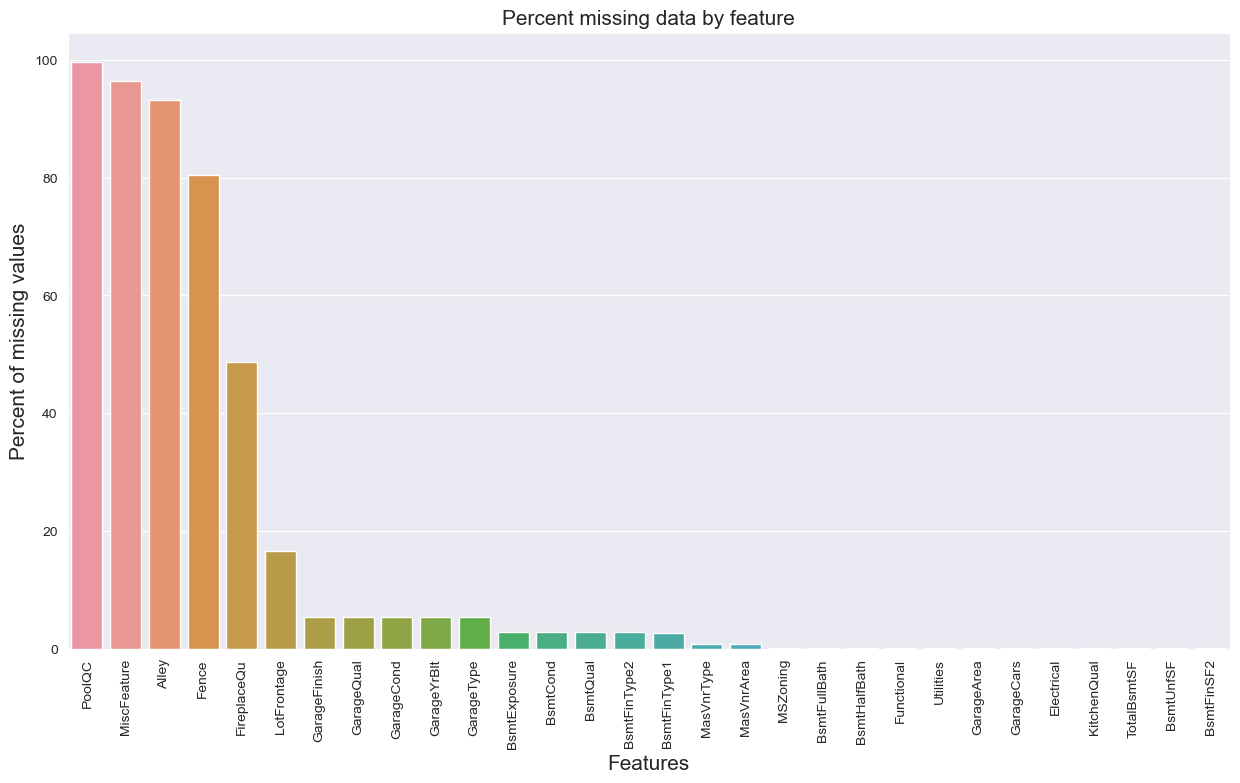

In [7]:
# Vẽ đồ thị cột thể hiện tỉ lệ thuộc tính bị thiếu của từng đặc trưng
f, ax = plt.subplots(figsize=(15, 8))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na.values)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

- Như vậy chúng ta có thể thấy có 4 đặc trưng có tỉ lệ missing values khá cao, lần lượt là **'PoolQC', 'Fence', 'MiscFeature'** và **'Alley'**. Chúng ta sẽ xử lý các "missing values" này cũng như các "missing values" khác.

- Dựa trên hình ảnh bên dưới, chúng ta có thể chắc chắn rằng hầu hết tất cả các ngôi nhà ở Ames đều có giá khoảng \$100000 đến \$200000. Và phân bố này cũng bị lệch phải

C:\Users\Bang\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 180921.20 and sigma = 79415.29



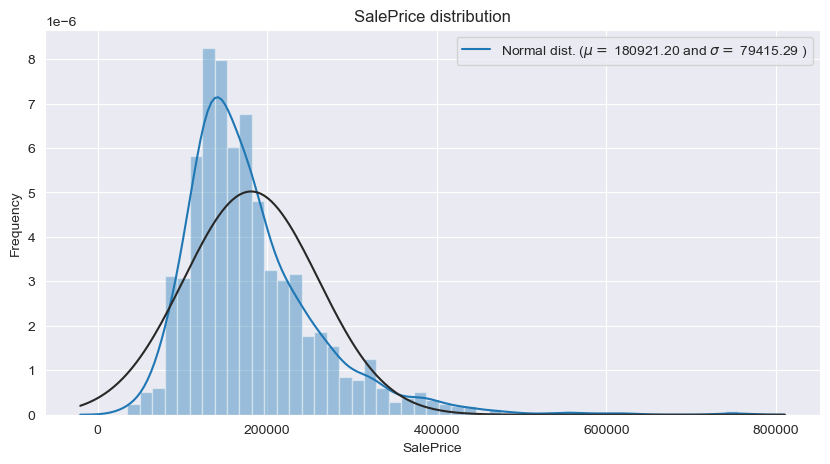

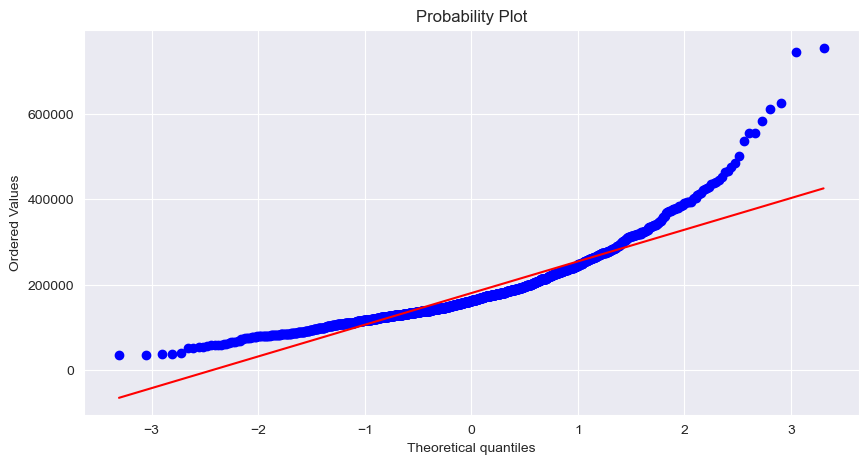

In [8]:
plt.subplots(figsize=(10,5))
sns.distplot(y, fit=norm);

# Tìm trung bình và độ lệch chuẩn của phân phối normal khớp với dữ liệu y
(mu, sigma) = norm.fit(y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Vẽ đồ thị QQ-plot
fig = plt.figure(figsize=(10,5))
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

- Chúng ta cũng sẽ tìm hiểu mối tương quan giữa các tính chất của mô nhà bằng ma trận tương quan. Theo như bảng dưới mô tả thì có khá nhiều dữ liệu dạng số có độ tương quan cao với giá nhà. Mặc khác, một vài tính chất của ngôi nhà có độ tương quan thấp giá bán như **'MSSubClass', 'OverallCond', 'YrSold'** và **'MoSold'** vốn dĩ là biến hạng mục mặc dù mang giá trị số.

<AxesSubplot:>

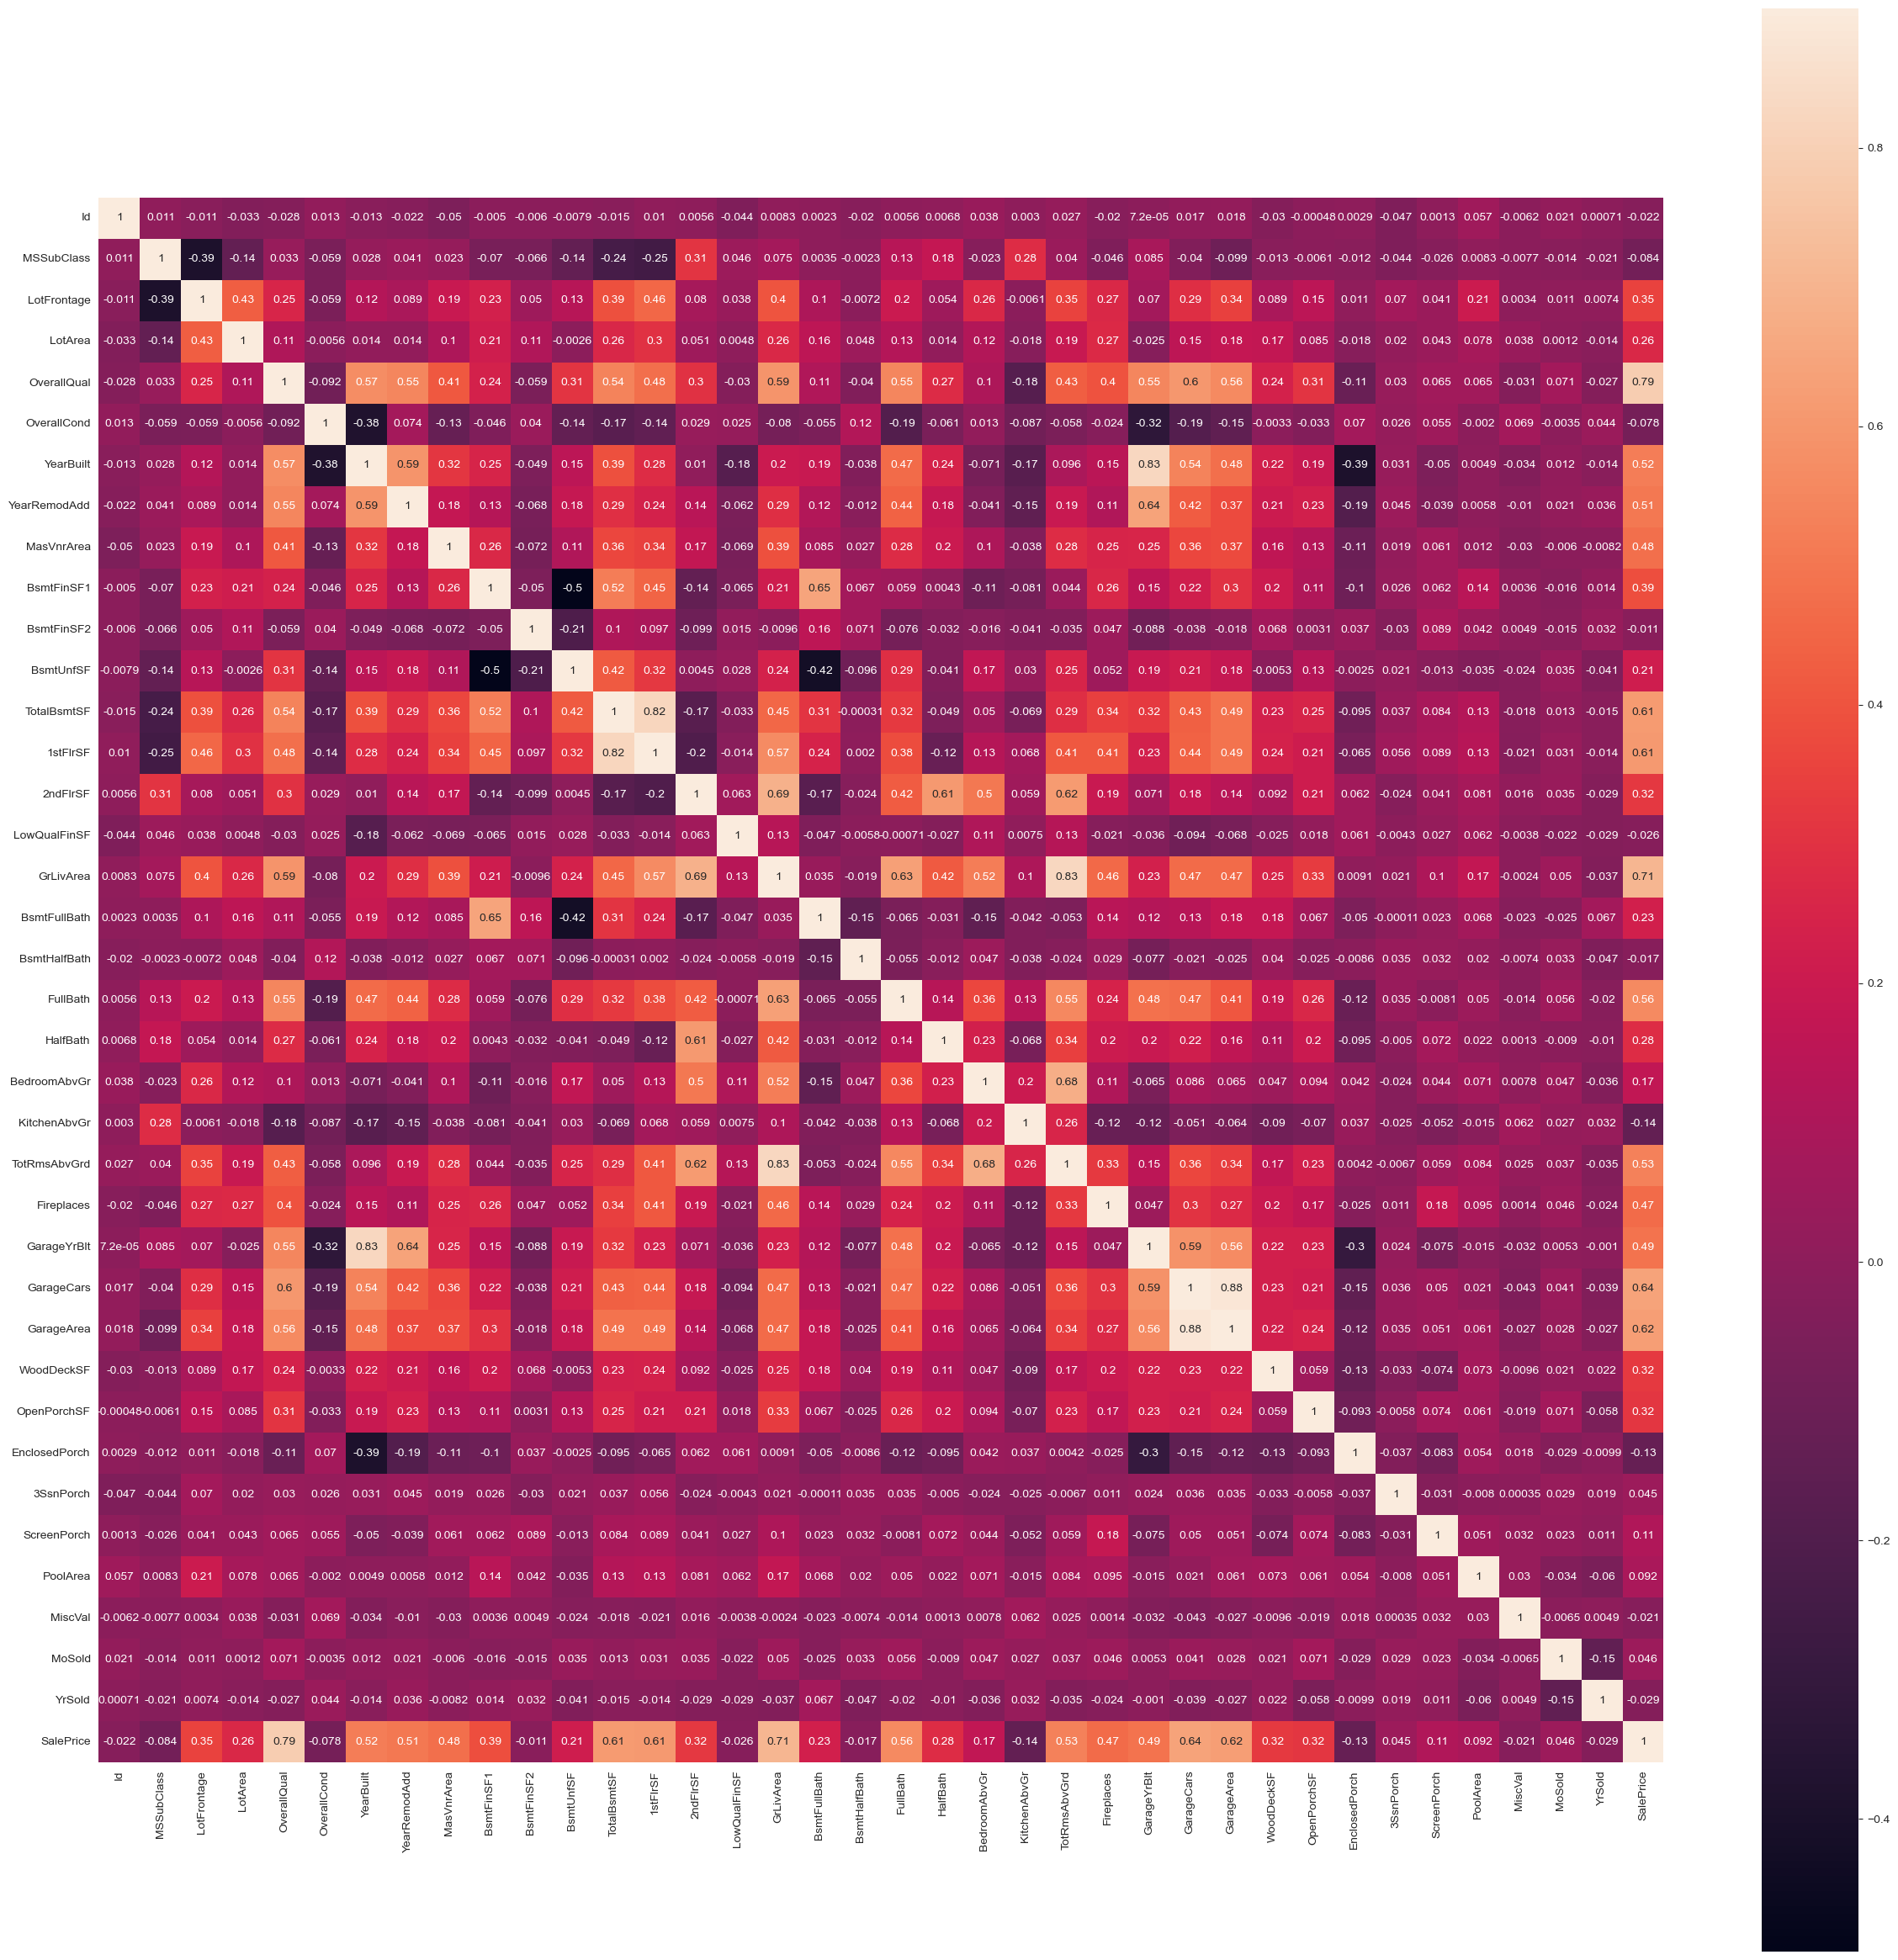

In [9]:
# Tìm ma trận tương quan của tập train
corrmat = train.corr()
plt.subplots(figsize=(30,30))
sns.heatmap(corrmat, vmax=0.9, square=True, annot=True)

# 2. Tiền xử lý dữ liệu

- Nạp lại tập dữ liệu

In [10]:
# Nạp 'train.csv' và 'test.csv'
train = pd.read_csv('./dataset/train.csv')
test = pd.read_csv('./dataset/test.csv')

# Chúng ta sẽ kết hợp 2 tập dữ liệu train và test ở các bước sau để xử lý
# tiền dữ liệu nên phải cần lưu lại số lượng dữ liệu ở mỗi tập để tách chúng
# trở lại
ntrain = train.shape[0]
ntest = test.shape[0]

# Đặc trưng cần được dự đoán
y = train.SalePrice.values

# all_data được sử dụng để xử lý data ở bước 2:
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

- Do đặc trưng **Id** chỉ mang ý nghĩa thứ tự của dữ liệu trong tập dữ liệu nên ta có thể xóa nó là không làm ảnh hưởng đến chất lượng của mô hình

In [11]:
# In chiều dữ liệu trước khi xóa cột 'Id'
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Tách cột Id ra riêng phòng trường hợp sử dụng khi cần thiết
train_ID = train['Id']
test_ID = test['Id']

# Xóa cột 'Id' trong tập dữ liệu train và test
train.drop("Id", axis = 1, inplace = True)
test.drop('Id', axis = 1, inplace = True)

# In chiều dữ liệu sau khi xóa cột 'Id'
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


Chúng ta xử lý các giá trị bị thiếu bằng cách xử lý tuần tự từng đặc trưng có giá trị bị thiếu.

## 2.1 Xử lý đặc trưng bị thiếu

- Ở phần này, chúng ta sẽ điền vào các giá trị dữ liệu đang bị thiếu (khuyết) tùy vào tính chất và ý nghĩa của các đặc trưng trong bảng dữ liệu.

In [12]:
all_data_nomissing = all_data.copy()

- **PoolQC**: mô tả dữ liệu cho biết NA có nghĩa là "No  Pool". Điều đó khá dễ hiểu, với tỷ lệ giá trị bị thiếu rất lớn (hơn 99%) và phần lớn các ngôi nhà nói chung không có hồ bơi, thay thế dữ liệu bằng 'None'

- **MiscFeature** : mô tả dữ liệu cho biết NA có nghĩa là "no misc feature", thay thế dữ liệu bằng 'None'

- **Alley** : mô tả dữ liệu cho biết NA có nghĩa là "no alley access", thay thế dữ liệu bằng 'None'

- **Fence** : mô tả dữ liệu cho biết NA có nghĩa là "no fence", thay thế dữ liệu bằng 'None'

- **FireplaceQu** : mô tả dữ liệu cho biết NA có nghĩa là "no fireplace", thay thế dữ liệu bằng 'None'

- **MSSubClass** : Na rất có thể có nghĩa là "no building class". Chúng ta có thể thay thế các giá trị bị thiếu bằng "None"

- **GarageType, GarageFinish, GarageQual** và **GarageCond** : thay thế dữ liệu bằng 'None'

In [13]:
missing_cols_group1 = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 
                       'FireplaceQu', 'MSSubClass', 'GarageType', 
                       'GarageFinish', 'GarageQual', 'GarageCond']
# Điền dữ liệu bị thiếu bằng giá trị 'None'
for col in missing_cols_group1:
    all_data_nomissing[col] = all_data[col].fillna('None')

- **LotFrontage** : chúng ta có thể **điền các giá trị còn thiếu bằng giá trị trung bình LotFrontage của khu vực lân cận**. (do các ngôi nhà trong các khu vực gần nhau thường có diện tích tương đồng)

In [14]:
#Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
# Điền dữ liệu bị thiếu bằng giá trị median
all_data_nomissing["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

- **GarageYrBlt, GarageArea** và **GarageCars** : Thay thế dữ liệu bị thiếu bằng 0 (Vì Không có ga ra đồng nghĩa không có ô tô nào trong ga ra đó và diện tích của ga ra bằng 0.)

- **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath** và **BsmtHalfBath** : Thay thế dữ liệu bị thiếu bằng 0 (ý nghĩa tương tự như ga ra)

- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1** và **BsmtFinType2** : Thay thế dữ liệu bị thiếu bằng 'None' (ý nghĩa tương tự như ga ra)

In [15]:
missing_cols_group3 = ['GarageYrBlt', 'GarageArea', 'GarageCars', 
                       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
# Điền dữ liệu bị thiếu bằng giá trị 0
for col in missing_cols_group3:
    all_data_nomissing[col] = all_data[col].fillna(0)

In [16]:
missing_cols_group4 = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
# Điền dữ liệu bị thiếu bằng giá trị 'None'
for col in missing_cols_group4:
    all_data_nomissing[col] = all_data[col].fillna('None')

- **MasVnrArea** and **MasVnrType** : NA rất có thể có nghĩa là không có ván xây cho những ngôi nhà này. Chúng ta có thể điền 0 cho Area và None cho Type.

In [17]:
# Điền dữ liệu bị thiếu bằng giá trị 'None' và 0 tùy vào đặc trưng
all_data_nomissing["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data_nomissing["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

- **MSZoning (The general zoning classification)** :  'RL' là giá trị phổ biến nhất. Vì vậy, chúng ta có thể điền vào các giá trị còn thiếu bằng 'RL'

In [18]:
# Điền dữ liệu bị thiếu bằng giá trị mode
all_data_nomissing["MSZoning"] = all_data["MSZoning"].fillna(all_data["MSZoning"].mode()[0])

- **Functional** : mô tả dữ liệu cho biết NA có nghĩa là chức năng điển hình, chúng ta điền các giá trị bị thiếu bằng "Typ"

- **Electrical** : Nó chỉ có một giá trị NA. Vì giá trị của đặc trưng này chủ yếu là 'SBrkr', nên chúng ta có thể đặt giá trị đó cho giá trị còn thiếu.

- **KitchenQual**: tương tự với Electrical, chúng ta đặt 'TA' (là giá trị phổ biến nhất) cho dữ liệu bị thiếu trong KitchenQual.

- **Exterior1st và Exterior2nd** : tương tự với Electrical, điền các giá trị bị thiếu bằng giá trị phổ biến nhất

- **SaleType** : tương tự với Electrical, điền các giá trị bị thiếu bằng giá trị phổ biến nhất

In [19]:
# Điền dữ liệu bị thiếu bằng giá trị 'Typ'
all_data_nomissing["Functional"] = all_data['Functional'].fillna("Typ")

In [20]:
from sklearn.impute import SimpleImputer

missing_cols_group5 = ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Utilities']
# Sử dụng SimpleImputer để điền các giá trị bị thiếu 
# trong bảng dữ liệu bằng giá trị phổ biến nhất
si = SimpleImputer(strategy='most_frequent')
all_data_nomissing[missing_cols_group5] = si.fit_transform(all_data[missing_cols_group5])

- Kiểm tra các giá trị bị thiếu còn tồn tại hay không

In [21]:
# Làm tương tự như ở phần 1
all_data_na = (all_data_nomissing.isnull().sum() / len(all_data_nomissing)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data

,Missing Ratio


Tập dữ liệu đã không còn các giá trị bị thiếu.

## 2.2 Xử lý biến dữ liệu số thật ra là biến hạng mục

- Tiếp theo, chúng ta biến đổi một số biến giá trị số thực ra là biến hạng mục

In [22]:
all_data_nomissing_2 = all_data_nomissing.copy()

In [23]:
# 'MSSubClass' được biến thổi thành biến hạng mục.
# Changing 'OverallCond' thành biến hạng mục
# 'YrSold' and 'MoSold' được biến đổi thành hạng mục.

fake_nummeric_cols = ['MSSubClass', 'OverallQual', 'OverallCond', 'YrSold', 'MoSold']
# Đổi định dạng của các đặc trưng số sang định dạng chuỗi (string)
for col in fake_nummeric_cols:
    all_data_nomissing_2[col] = all_data[col].astype(str)

## 2.3 Thêm một vài đặc trưng mới theo suy luận

In [24]:
all_data_nomissing_3 = all_data_nomissing_2.copy()

In [25]:
all_data_nomissing_3.shape

(2919, 80)

Vì các đặc điểm liên quan đến diện tích rất quan trọng để xác định giá nhà nên chúng ta bổ sung thêm một đặc điểm nữa là tổng diện tích tầng hầm, diện tích tầng 1 và tầng 2 của mỗi ngôi nhà

In [26]:
all_data_nomissing_3['TotalSF'] = all_data_nomissing_3['TotalBsmtSF'] + all_data_nomissing_3['1stFlrSF'] + all_data_nomissing_3['2ndFlrSF']

## 2.4 Mã hóa số nguyên (Label encoding) một số biến hạng mục.

In [27]:
all_data_nomissing_4 = all_data_nomissing_3.copy()

In [28]:
def label_encoding(data, values_in_feature):
    return values_in_feature.index(data) 

- **'OverallQual', 'OverallCond'**: có các label là **'1', '2', '3', '4', '5', '6', '7', '8', '9', '10'**

In [31]:
#Ta thêm '0' vào để thuận tiện cho việc mã hóa theo index
labels_0 = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'] 
labels_columns_0 = ['OverallQual', 'OverallCond']

# mã hóa số nguyên bằng cách sử dụng hàm label_encoding
for col in labels_columns_0:
    all_data_nomissing_4[col] = all_data_nomissing_3[col].apply(lambda x: label_encoding(x, labels_0))

all_data_nomissing_4[labels_columns_0].head()

,OverallQual,OverallCond
0,7,5
1,6,8
2,7,5
3,7,5
4,8,5


- **'BsmtQual', 'BsmtCond', 'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PoolQC'** có chung các label là **'None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'**

In [36]:
labels_1 = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
labels_columns_1 = ['BsmtQual', 'BsmtCond', 'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PoolQC']

# mã hóa số nguyên bằng cách sử dụng hàm label_encoding
for col in labels_columns_1:
    all_data_nomissing_4[col] = all_data_nomissing_3[col].apply(lambda x: label_encoding(x, labels_1))

all_data_nomissing_4[labels_columns_1].head()

,BsmtQual,BsmtCond,ExterQual,ExterCond,HeatingQC,KitchenQual,PoolQC
0,4,3,4,3,5,4,0
1,4,3,3,3,5,3,0
2,4,3,4,3,5,4,0
3,3,4,3,3,4,4,0
4,4,3,4,3,5,4,0


- **'BsmtExposure'** có các label là **'None', 'No', 'Mn', 'Av', 'Gd'**

In [32]:
labels_2 = ['None', 'No', 'Mn', 'Av', 'Gd']
labels_columns_2 = ['BsmtExposure']

# mã hóa số nguyên bằng cách sử dụng hàm label_encoding
for col in labels_columns_2:
    all_data_nomissing_4[col] = all_data_nomissing_3[col].apply(lambda x: label_encoding(x, labels_2))
    
all_data_nomissing_4[labels_columns_2].head()

,BsmtExposure
0,1
1,4
2,2
3,1
4,3


- **'BsmtFinType1', 'BsmtFinType2'** có chung các label là **'None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'**

In [33]:
labels_3 = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
labels_columns_3 = ['BsmtFinType1', 'BsmtFinType2']

# mã hóa số nguyên bằng cách sử dụng hàm label_encoding
for col in labels_columns_3:
    all_data_nomissing_4[col] = all_data_nomissing_3[col].apply(lambda x: label_encoding(x, labels_3))
    
all_data_nomissing_4[labels_columns_3].head()

,BsmtFinType1,BsmtFinType2
0,6,1
1,5,1
2,6,1
3,5,1
4,6,1


- **'CentralAir'** có các label là **'N', 'Y'**
- **'GarageFinish'** có các label là **'None', 'Unf', 'RFn', 'Fin'**
- **'Fence'** có các label là **'None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'**

In [34]:
labels_4 = ['N', 'Y']
labels_columns_4 = ['CentralAir']

labels_5 = ['None', 'Unf', 'RFn', 'Fin']
labels_columns_5 = ['GarageFinish']

labels_6 = ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
labels_columns_6 = ['Fence']

# mã hóa số nguyên bằng cách sử dụng hàm label_encoding
for col in labels_columns_4:
    all_data_nomissing_4[col] = all_data_nomissing_3[col].apply(lambda x: label_encoding(x, labels_4))

for col in labels_columns_5:
    all_data_nomissing_4[col] = all_data_nomissing_3[col].apply(lambda x: label_encoding(x, labels_5))
    
for col in labels_columns_6:
    all_data_nomissing_4[col] = all_data_nomissing_3[col].apply(lambda x: label_encoding(x, labels_6))
    
all_data_nomissing_4[labels_columns_4 + labels_columns_5 + labels_columns_6].head()

,CentralAir,GarageFinish,Fence
0,1,2,0
1,1,2,0
2,1,2,0
3,1,1,0
4,1,2,0


- Danh sách các cột được mã hóa số nguyên

In [37]:
label_cols = labels_columns_0 + labels_columns_1 + labels_columns_2 + labels_columns_3 + labels_columns_4 + labels_columns_5 + labels_columns_6
label_cols

['OverallQual',
 'OverallCond',
 'BsmtQual',
 'BsmtCond',
 'ExterQual',
 'ExterCond',
 'HeatingQC',
 'KitchenQual',
 'PoolQC',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'CentralAir',
 'GarageFinish',
 'Fence']

## 2.5 Mã hóa One-hot (One-hot encoding) biến hạng mục

In [38]:
all_data_nomissing_5 = all_data_nomissing_3.copy()
# Tách riêng các cột không chứa các đặc trưng đã được mã hóa số nguyên
number_categorical_cols = [col for col in all_data_nomissing_3.columns if col not in label_cols] 

In [39]:
number_categorical_cols

['Id',
 'MSSubClass',
 'MSZoning',
 'LotFrontage',
 'LotArea',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'Foundation',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Heating',
 'Electrical',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Functional',
 'Fireplaces',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition',
 'TotalSF']

- Bây giờ chúng ta bắt đầu quá trình làm sạch dữ liệu, sau đó chúng ta sẽ xử lý các giá trị dữ liệu số và hạng mục riêng biệt. Chúng ta sẽ chia các cột dữ liệu vào 2 loại chính: Dữ liệu số ('int64' hoặc 'float64') và hạng mục ('object').

In [40]:
# Danh sách các đặc trưng là dữ liệu số
number_cols = [col for col in number_categorical_cols if all_data_nomissing_3[col].dtype=='int64' or all_data_nomissing_3[col].dtype=='float64'] # Numerical

# Danh sách các đặc trưng là dữ liệu hạng mục
categorical_cols=[col for col in number_categorical_cols if all_data_nomissing_3[col].dtype=='object'] # Categorical

In [41]:
print(len(number_cols), len(categorical_cols), len(all_data_nomissing_3.columns))

33 33 81


Chúng ta sẽ mã hóa dữ liệu hạng mục bằng phương pháp mã hóa **One-hot Encoding**

- Sử dụng hàm get_dummies() để mã hóa dữ liệu dạng hạng mục

In [42]:
# Tách riêng tập dữ liệu hạng mục và sử dụng get_dummies
cat_data = all_data_nomissing_5[categorical_cols].copy()
cat_data_dummy = pd.get_dummies(cat_data)

print(cat_data_dummy.shape)

(2919, 237)


## 2.6 Co dãn dữ liệu số

- Chúng ta sẽ co dãn dữ liệu số thành dữ liệu ở dạng **phân phối chuẩn**

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Tách riêng tập dữ liệu số và sử dụng StandardScaler
all_data_nomissing_5[number_cols] = scaler.fit_transform(all_data_nomissing_5[number_cols])

- Kết hợp các tập dữ liệu

In [44]:
# Kết hợp tập dữ liệu số và tập dữ liệu hạng mục sau khi đã xử lý
# thành một tập dữ liệu mới
all_data_nomissing_6 = pd.concat([all_data_nomissing_5[number_cols].copy(), cat_data_dummy, all_data_nomissing_4[label_cols]], axis=1)

In [45]:
all_data_nomissing_6.shape

(2919, 285)

In [46]:
cat_data_dummy

,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2915,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2916,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [47]:
cat_data_dummy.shape

(2919, 237)

# 3. Lựa chọn đặc trưng

  - Sử dụng mô hình hồi quy **Lasso** để lựa chọn đặc trưng

## Loại bỏ  các đặc trưng bị trùng

In [48]:
from feature_engine.selection import DropDuplicateFeatures

In [49]:
# Loại bỏ các đặc trưng bị trùng bằng hàm DropDuplicateFeatures
sel = DropDuplicateFeatures(variables=None, missing_values='raise')

sel.fit(all_data_nomissing_6)

DropDuplicateFeatures(missing_values='raise')

In [50]:
sel.duplicated_feature_sets_

[{'BldgType_Duplex', 'MSSubClass_90'}, {'GarageCond_None', 'GarageQual_None'}]

In [51]:
sel.features_to_drop_

{'BldgType_Duplex', 'GarageCond_None'}

In [52]:
# Tiến hành loại bỏ đặc trưng bị trùng
all_data_preprocessed = sel.transform(all_data_nomissing_6)

all_data_preprocessed.shape

(2919, 283)

- Tách tập dữ liệu thành tập train và test cho mục đích lựa chọn đặc trưng

In [53]:
train_preprocessed = all_data_preprocessed.iloc[:ntrain,:].copy()
test_preprocessed = all_data_preprocessed.iloc[ntrain:,:].copy()

In [54]:
train_preprocessed.shape

(1460, 283)

## 3.1 Lựa chọn đặc trưng bằng mô hình Lasso

- Sử dụng hồi quy **Lasso** để lựa chọn các đặc trưng phù hợp cho mô hình

In [55]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

- Sử dụng **GridSearchCV** để lựa chọn mô hình Lasso tốt nhất có thể, sau đó sử dụng mô hình này để lựa chọn các đặc trưng

**Lưu ý**: sử dụng độ đo **MSE** (Mean squared error)

In [56]:
parameters = {'alpha':[0.01, 1, 10, 100]}
model = Lasso(normalize=True)
# Khởi tạo lưới tìm kiếm trên mô hình Lasso
clf = GridSearchCV(model, param_grid=parameters, scoring = 'neg_mean_squared_error')
clf.fit(train_preprocessed, y)

C:\Users\Bang\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(
C:\Users\Bang\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e+11, toleran

C:\Users\Bang\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.552e+09, tolerance: 7.249e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\Bang\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to

GridSearchCV(estimator=Lasso(normalize=True),
             param_grid={'alpha': [0.01, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [57]:
clf.best_params_

{'alpha': 10}

In [58]:
# Tiến hành lựa chọn đặc trưng
sel = SelectFromModel(Lasso(alpha = clf.best_params_['alpha'], normalize=True))
sel.fit(train_preprocessed, y)

C:\Users\Bang\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


SelectFromModel(estimator=Lasso(alpha=10, normalize=True))

In [59]:
# Danh sách đặc trưng chúng ta chọn giữ lại
selected_feat = train_preprocessed.columns[(sel.get_support())]

# Số đặc trưng trước khi giảm
print('total features: {}'.format((train_preprocessed.shape[1])))

# Số đặc trưng sau khi giảm
print('selected features: {}'.format(len(selected_feat)))

# Số đặc trưng đã được loại bỏ
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel.estimator_.coef_ == 0)))

total features: 283
selected features: 154
features with coefficients shrank to zero: 127


In [60]:
selected_feat

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       ...
       'OverallCond', 'BsmtQual', 'BsmtCond', 'ExterQual', 'ExterCond',
       'HeatingQC', 'KitchenQual', 'PoolQC', 'BsmtExposure', 'GarageFinish'],
      dtype='object', length=154)

- Chọn tập dữ liệu mới với các đặc trưng đã lựa chọn

In [61]:
train_lasso_selected = train_preprocessed[selected_feat]
test_lasso_selected = test_preprocessed[selected_feat]

# 4. Đánh giá hiệu quả mô hình

Chúng ta sẽ sử dụng phương pháp **K-fold cross validation** (kiểm chứng chéo) để đánh giá độ hiệu quả của các mô hình trong việc đưa ra dự đoán.

In [62]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.linear_model import Ridge, LinearRegression

- Xây dựng hàm kiểm chứng chéo bằng cách sử dụng hàm **cross_val_score** và **KFold** của sklearn. Tuy nhiên, hàm này không có đặc trưng xáo trộn, chúng ta thêm vào một dòng mã dùng để xáo trộn tập dữ liệu trước khi kiểm chứng chéo. Điều này giúp có được kết quả khách quan hơn.

In [63]:
# Số fold bằng 10
n_folds = 10

def rmse_cv(model, train, y):
  
    # Tạo danh sách các fold
    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(train.values)

    # Tiến hành kiểm chứng chéo với metric là MSE
    mse= np.sqrt(-cross_val_score(model, train.values, np.log(y), scoring="neg_mean_squared_error", cv = kf))

    # Trả về mảng giá trị MSE của từng fold
    return(mse)

## 4.1 Các mô hình cơ sở

- Sử dụng hai mô hình hồi quy để huấn luyện và so sánh: mô hình cơ bản và mô hình hồi quy Ridge

### Linear Regression

In [64]:
model = LinearRegression()
score = rmse_cv(model, train_lasso_selected, y)
print("Lasso Selection: Averaged base models score: {:.4f}\n".format(score.mean()))

Lasso Selection: Averaged base models score: 28552393412.8318



### Ridge Regression

In [65]:
model = Ridge(alpha = 1e+3, tol = 0.0001, random_state=0)

# Kiểm chứng chéo trên các tập dữ liệu đã được lựa chọn thuộc tính

score = rmse_cv(model, train_lasso_selected, y)
print("Lasso Selection: Averaged base models score: {:.4f}\n".format(score.mean()))

Lasso Selection: Averaged base models score: 0.1496



# 5. Kết luận

Có thể thấy, **mô hình Hồi quy** có hai tác vụ khó khăn nhất để giải quyết nếu muốn xây dựng một mô hình tốt (những tác vụ này cần kinh nghiệm thực tiễn):

- Đầu tiên là **dữ liệu**, dữ liệu chúng ta sở hữu có thể không đủ hoặc chúng có thể chứa các giá trị bị thiếu trong một số đặc trưng. Đối với vấn đề này, chúng ta có thể sử dụng một số kỹ thuật bao gồm **điền dữ liệu còn thiếu, thêm và bớt một số đặc trưng hoặc xử lý dữ liệu hạng mục (và số)** theo những cách cụ thể.



- Thứ hai là **chọn đúng mô hình**. Trong thực tế, dữ liệu có một số lượng lớn các đặc trưng (là thứ nguyên của dữ liệu). Vì vậy, thực sự khó để chọn được mô hình phù hợp bởi trực giác của con người nếu không có kinh nghiệm. Ngay cả khi bạn chọn đúng mô hình thì còn rất nhiều việc phải làm, bạn nên điều chỉnh các thông số (với tìm kiếm lưới hoặc tìm kiếm ngẫu nhiên) của mô hình này để tránh hiện tượng overfitting và underfitting.

Mặc dù kết quả là khá tốt, chúng ta có thể thực hiện những cách khác để có một mô hình tốt hơn nữa. Chúng ta có thể xây dựng một mô hình hồi quy khác hoặc chúng ta có thể thực hiện một số kỹ thuật làm sạch hiện đại hơn để có dữ liệu tốt hơn.